## Modeling the Neo4j DB



In [1]:
import pandas as pd

/home/michael/anaconda2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [79]:
def loadData(filePath):
    with open(filePath) as f:
        data = f.read().split('\n')
    elements = []
    for line in data:
        el = line.split()
        try:
            elements.append([el[0],el[4], ' '.join(el[7:])])
        except:
            pass
    
    #Build Dataframe
    df = pd.DataFrame(elements, columns=['timestamp','AP','message'])
    df.drop_duplicates(inplace=True)
    
    df['Disassociating'] = df.message.str.extract(r'Disassociating (\w+)', expand=False)
    df['Station'] = df.message.str.extract(r'Station (\w+)', expand=False)
    df['Action'] = df.message.str.extract(r'Station \w+ (\w+)', expand=False)
    
    df.ix[ ~ df.Disassociating.isnull(),'Station'] = df.ix[ ~ df.Disassociating.isnull(),'Disassociating']
    df.ix[ ~ df.Disassociating.isnull(),'Action'] = 'Disassociating'
    
    df['Deauthenticating'] = df.message.str.extract(r'Deauthenticating (\w+)', expand=False)
    df.ix[ ~ df.Deauthenticating.isnull(),'Station'] = df.ix[ ~ df.Deauthenticating.isnull(),'Deauthenticating']
    df.ix[ ~ df.Deauthenticating.isnull(),'Action'] = 'Deauthenticating'
    
    df.drop(['Disassociating','Deauthenticating'], axis=1, inplace=True)
    
    
    df['BuildingType'] = df.AP.str.extract(r'(\w+)Bldg', expand=False)
    df['BuildingNumber'] = df.AP.str.extract(r'Bldg(\d+)', expand=False)
    df['APnumber'] = df.AP.str.extract(r'AP(\d+)', expand=False)
    df['BuildingId'] = df.BuildingType + df.BuildingNumber
    return df

In [80]:
fname = "/home/michael/Documents/syslog-v3.3/20010411.log"

In [81]:
df = loadData(fname)

In [82]:
df.head()

,timestamp,AP,message,Station,Action,BuildingType,BuildingNumber,APnumber,BuildingId
0,986990216,AdmBldg19AP3,Station 0040961e58be Authenticated,0040961e58be,Authenticated,Adm,19,3,Adm19
1,986990247,AdmBldg19AP3,Station 0040961e58be Authenticated,0040961e58be,Authenticated,Adm,19,3,Adm19
2,986990247,AdmBldg19AP3,Station 0040961e58be Associated,0040961e58be,Associated,Adm,19,3,Adm19
3,986990293,AdmBldg19AP3,Station 0040961e58be Authenticated,0040961e58be,Authenticated,Adm,19,3,Adm19
4,986990364,AdmBldg19AP3,Station 0040961e58be Authenticated,0040961e58be,Authenticated,Adm,19,3,Adm19


In [5]:
from py2neo import Graph, authenticate, Relationship

In [6]:
graph = Graph(user="neo4j", password="admin")

In [83]:
#erase db
graph.run('''
MATCH (n)
DETACH DELETE n
''')

## Add nodes

In [84]:
departements = list(set(df.BuildingType))
departements

['Soc', 'Adm', 'Lib', 'Acad']

In [88]:
buildings = list(set(df.BuildingId))
buildings

['Acad1',
 'Acad4',
 'Acad33',
 'Acad16',
 'Soc1',
 'Adm19',
 'Adm16',
 'Lib2',
 'Adm12']

In [89]:
ap = list(set(df.AP))

In [91]:
for d in departements:
    graph.run('''
    MERGE (:DEPARTEMENT {Type: {N}})
    ''', {'N': d})

In [92]:
for b in buildings:
    graph.run('''
    MERGE (:BUILDING {Number: {N}})
    ''', {'N': b})

In [93]:
for a in ap:
    graph.run('''
    MERGE (:AP {Number: {N}})
    ''', {'N': a})

In [94]:
for s in stations:
    graph.run('''
    MERGE (:STATION {Number: {N}})
    ''', {'N': s})

In [97]:
for i,row in df.iterrows():
    graph.run('''
    
    MATCH (d:DEPARTEMENT), (b:BUILDING), (a:AP)
    
    WHERE d.Type = {DEP} AND b.Number = {BUILD} AND a.Number = {AP}
    
    MERGE (d)-[:HAS_BUILDING]->(b)
    MERGE (b)-[:HAS_AP]->(a)
    
    ''',{'DEP':row.BuildingType, 'BUILD':row.BuildingId, 'AP':row.AP})

In [98]:
graph.run('''
MATCH (n)-[r]->(b)
RETURN * LIMIT 3
''').data()

[{u'b': (b71f647:BUILDING {Number:"Acad1"}),
  u'n': (d537538:DEPARTEMENT {Type:"Acad"}),
  u'r': (d537538)-[:HAS_BUILDING]->(b71f647)},
 {u'b': (e8e3e24:BUILDING {Number:"Acad4"}),
  u'n': (d537538:DEPARTEMENT {Type:"Acad"}),
  u'r': (d537538)-[:HAS_BUILDING]->(e8e3e24)},
 {u'b': (b55ed53:BUILDING {Number:"Acad33"}),
  u'n': (d537538:DEPARTEMENT {Type:"Acad"}),
  u'r': (d537538)-[:HAS_BUILDING]->(b55ed53)}]

## Add the stations



In [99]:
set(df.Action)

{nan,
 'Associated',
 'Authenticated',
 'Deauthenticating',
 'Disassociating',
 'Reassociated',
 'roamed'}

In [90]:
stations = list(set(df.ix[~df.Station.isnull(),'Station']))

In [100]:
len(stations)

28

In [102]:
for i,row in df.iterrows():
    graph.run('''
    
    MATCH (s:STATION), (b:BUILDING), (a:AP)
    
    WHERE s.Number = {NUM} AND b.Number = {BUILD} AND a.Number = {AP}
    
    MERGE (s)-[:INTERACT {Action: {R}, Timestamp: toInteger({T})}]->(a)<-[:HAS_AP]-(b)
    
    
    ''',{'NUM':row.Station, 'BUILD':row.BuildingId, 'AP':row.AP, 'R':row.Action, 'T': row.timestamp})

In [136]:
graph.run('''
MATCH (s:STATION)-[r]->(a:AP)
WHERE s.Number = "00409699915b"
RETURN COUNT(r) AS INTERACTIONS, a.Number AS BUILDING, COUNT(DISTINCT a.Number) AS NUM_APs
''').data()

[{u'BUILDING': u'AcadBldg33AP6', u'INTERACTIONS': 3, u'NUM_APs': 1},
 {u'BUILDING': u'AcadBldg33AP5', u'INTERACTIONS': 4, u'NUM_APs': 1},
 {u'BUILDING': u'LibBldg2AP7', u'INTERACTIONS': 143, u'NUM_APs': 1},
 {u'BUILDING': u'AcadBldg33AP1', u'INTERACTIONS': 7, u'NUM_APs': 1}]

This station went to the Academic building 33, but spent most of the day at the library.

## What is the sequence of interactions between the stations and APs ?

In [133]:
actions = graph.run('''
MATCH (s:STATION)-[r]->(a:AP)
WHERE s.Number = "00409699915b"

RETURN COLLECT(r.Action) AS ACTIONS
''').data()

In [134]:
from collections import Counter

In [135]:
Counter(actions[0].values()[0])

Counter({u'Associated': 75,
         u'Authenticated': 75,
         u'Deauthenticating': 4,
         u'Reassociated': 1,
         u'roamed': 2})

In [132]:
df.ix[df.Station == "00409699915b"]

,timestamp,AP,message,Station,Action,BuildingType,BuildingNumber,APnumber,BuildingId
72,986992653,AcadBldg33AP1,Station 00409699915b Authenticated,00409699915b,Authenticated,Acad,33,1,Acad33
73,986992653,AcadBldg33AP1,Station 00409699915b Associated,00409699915b,Associated,Acad,33,1,Acad33
74,986992654,AcadBldg33AP1,Station 00409699915b Authenticated,00409699915b,Authenticated,Acad,33,1,Acad33
75,986992654,AcadBldg33AP1,Station 00409699915b Associated,00409699915b,Associated,Acad,33,1,Acad33
76,986992656,AcadBldg33AP1,Station 00409699915b Authenticated,00409699915b,Authenticated,Acad,33,1,Acad33
77,986992656,AcadBldg33AP1,Station 00409699915b Associated,00409699915b,Associated,Acad,33,1,Acad33
80,986992777,AcadBldg33AP6,Station 00409699915b Authenticated,00409699915b,Authenticated,Acad,33,6,Acad33
81,986992777,AcadBldg33AP6,Station 00409699915b Associated,00409699915b,Associated,Acad,33,6,Acad33
82,986992777,AcadBldg33AP1,Station 00409699915b roamed,00409699915b,roamed,Acad,33,1,Acad33
86,986993050,AcadBldg33AP5,Station 00409699915b Authenticated,00409699915b,Authenticated,Acad,33,5,Acad33


'Authenticaed' and 'Associated' are alwas concomitent.
Roamed indicates which AP was left for the new.

In [151]:
s = df.ix[df.Station == "00409699915b", 'timestamp']

In [195]:
s.sort_values(inplace=True)

In [154]:
import numpy as np

In [196]:
d = s.astype(np.int64).diff()

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

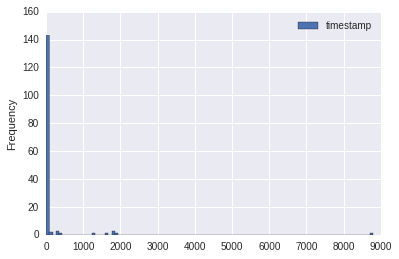

In [198]:
pd.DataFrame(d).plot.hist(bins=100)
#plt.ylim(0,10)
plt.show()

In [199]:
d_filter = [x/3600 for x in d if x > 10]

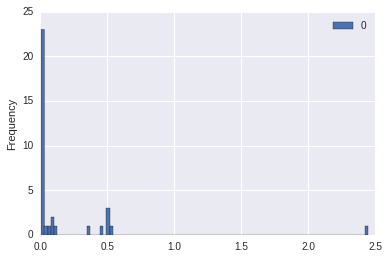

In [200]:
pd.DataFrame(d_filter).plot.hist(bins=100)
plt.xlabel='sec'
plt.show()

Most of the consecutive signals are less than 1 minute. But some breaks can got to half an hour.

In [201]:
end = s[-1:].astype(np.int64)

In [202]:
start = s[:1].astype(np.int64)

In [204]:
(int(end) - int(start))/3600

5

The total session time is 5 hours.